In [1]:
# Extract results

In [2]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import time
import json

import pandas as pd

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer, SharedVehicleLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_layer_from_roads
from mnms.vehicles.veh_type import Tram, Metro, Bus, Bike
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.mobility_service.vehicle_sharing import VehicleSharingMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, load_odlayer, save_transit_links
from mnms.tools.render import draw_roads, draw_line, draw_odlayer, draw_path, draw_veh_activity
#from mnms.tools.geometry import points_in_polygon, get_bounding_box
from mnms.time import Time

/Users/louis/opt/anaconda3/envs/mnms/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
### Parameters

# Files and directories
f = open('params.json')
params = json.load(f)

current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

#coord_csv_filepath = indir + 'KV1_GVB_2609_2/Csv/POINT.csv' # file with coordinates of the network
#amsterdam_json_filepath = indir + 'new_network.json' # mlgraph with the road network only
#amsterdam_json_filepath_pt_transit = indir + "network_pt_transit.json"
#transit_path = indir + "transit.json"

In [4]:
### Load network

mmgraph_pt = load_graph(indir + params["fn_network"])
df_stations = pd.read_csv(indir+params['fn_emoped_st_init'])

#df_emoped1 = pd.read_csv(indir + 'init_pos_emoped.csv')
#df_emoped2 = pd.read_csv(indir + 'init_pos_emoped.csv')

### Load demand

df_dmd = pd.read_csv(indir + params['fn_demand'], sep=";")

### Load odlayer
odlayer = load_odlayer(indir + params["fn_odlayer"])
x_od = []
y_od = []
for i in odlayer.origins.items():
    x = i[1][0]
    y = i[1][1]
    x_od.append(x)
    y_od.append(y)

In [5]:
## Load results

df_emoped1_notax = pd.read_csv(outdir+'notax/emoped1_veh.csv', sep=";")
df_path_notax = pd.read_csv(outdir+'notax/path.csv', sep=";")
df_users_notax = pd.read_csv(outdir+'notax/users.csv', sep=";")

df_emoped1_tax = pd.read_csv(outdir+'tax/emoped1_veh.csv', sep=";")
df_path_tax = pd.read_csv(outdir+'tax/path.csv', sep=";")
df_users_tax = pd.read_csv(outdir+'tax/users.csv', sep=";")

df_emoped1_subsidy = pd.read_csv(outdir+'subsidy/emoped1_veh.csv', sep=";")
df_path_subsidy = pd.read_csv(outdir+'subsidy/path.csv', sep=";")
df_users_subsidy = pd.read_csv(outdir+'subsidy/users.csv', sep=";")

df_emoped1_subsidytax = pd.read_csv(outdir+'subsidytax/emoped1_veh.csv', sep=";")
df_path_subsidytax = pd.read_csv(outdir+'subsidytax/path.csv', sep=";")
df_users_subsidytax = pd.read_csv(outdir+'subsidytax/users.csv', sep=";")

In [6]:
# Look vehicle trajectory
"""veh_id = 130
df = df_emoped1[df_emoped1["ID"] == int(veh_id)]
list_pos_emoped = np.zeros((len(df['POSITION']),2))
for i, row in enumerate(df['POSITION']):
    pos = row.split(' ')
    #plt.text(float(pos[0]), float(pos[1]), row.TIME)
    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]"""

'veh_id = 130\ndf = df_emoped1[df_emoped1["ID"] == int(veh_id)]\nlist_pos_emoped = np.zeros((len(df[\'POSITION\']),2))\nfor i, row in enumerate(df[\'POSITION\']):\n    pos = row.split(\' \')\n    #plt.text(float(pos[0]), float(pos[1]), row.TIME)\n    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]'

In [7]:
len(df_dmd)

6121

In [8]:
df_dmd

,ID,DEPARTURE,ORIGIN,DESTINATION
0,39445,16:00:00,628031.4237993133 5802602.155444146,630380.6151349074 5807027.511086608
1,11612,16:00:01,629281.134139592 5802092.283868504,628995.6331942925 5800649.764281734
2,35837,16:00:02,624680.7158940306 5801489.688037196,628073.5723049763 5803435.127865568
3,56283,16:00:02,628639.8575553824 5804125.078511461,627591.6090607818 5804410.940326173
4,31234,16:00:02,625289.3172866856 5803012.519745523,625252.1768589091 5804373.551610939
...,...,...,...,...
6116,26115,17:59:51,632662.5394628901 5797451.642763945,635126.4871575978 5797793.104756744
6117,38712,17:59:51,626342.3567087323 5804920.460137626,624680.7158940306 5801489.688037196
6118,48038,17:59:53,631626.1260627909 5804324.096896027,630250.1109811553 5802334.694690917
6119,28712,17:59:56,632905.9491026278 5798061.323962927,629486.9805566227 5804062.945860969


In [9]:
def calc_dist(row):
    pos1 = [float(x) for x in row.ORIGIN.split(' ')]
    pos2 = [float(x) for x in row.DESTINATION.split(' ')]
    #dist = abs(pos1[0]-pos2[0]) + abs(pos1[1]-pos2[1])
    dist = ((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)**0.5
    return dist

dist = df_dmd.apply(calc_dist, axis=1)

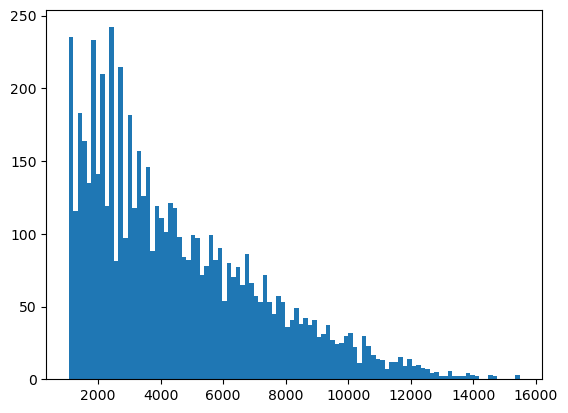

In [10]:
plt.hist(dist, bins=100);

In [11]:
# Look O/D for users wihtout paths
"""list_nomatch = []
list_origins = []
list_destinations = []
for i, row in df_path_notax[:].iterrows():
    if pd.isna(row['PATH']):
        list_nomatch.append(row['ID'])
        user = df_dmd[df_dmd['ID']==row['ID']]
        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])
        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])"""

"list_nomatch = []\nlist_origins = []\nlist_destinations = []\nfor i, row in df_path_notax[:].iterrows():\n    if pd.isna(row['PATH']):\n        list_nomatch.append(row['ID'])\n        user = df_dmd[df_dmd['ID']==row['ID']]\n        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])\n        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])"

In [12]:
"""id_user = '1066750-1'
o_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]
d_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]

dist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
dist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
print(np.argmin(dist_o), np.argmin(dist_d))"""

"id_user = '1066750-1'\no_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]\nd_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]\n\ndist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\ndist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\nprint(np.argmin(dist_o), np.argmin(dist_d))"

# Plot network

In [13]:
polygon = np.asarray(params['polygon_demand'])

In [14]:
x_st = []
y_st = []
for n in df_stations['closest_node']:
    x_st.append(mmgraph_pt.roads.nodes[n].position[0])
    y_st.append(mmgraph_pt.roads.nodes[n].position[1])

In [15]:
x_nodes = []
y_nodes = []
for key in mmgraph_pt.roads.nodes.keys():
    pos = mmgraph_pt.roads.nodes[key].position
    x_nodes.append(pos[0])
    y_nodes.append(pos[1])

In [16]:
print([p - polygon[0,0] for p in polygon[:,0]])
print([p - polygon[0,1] for p in polygon[:,1]])

[0.0, 23000.0, 23000.0, 0.0]
[0.0, 0.0, -20000.0, -20000.0]


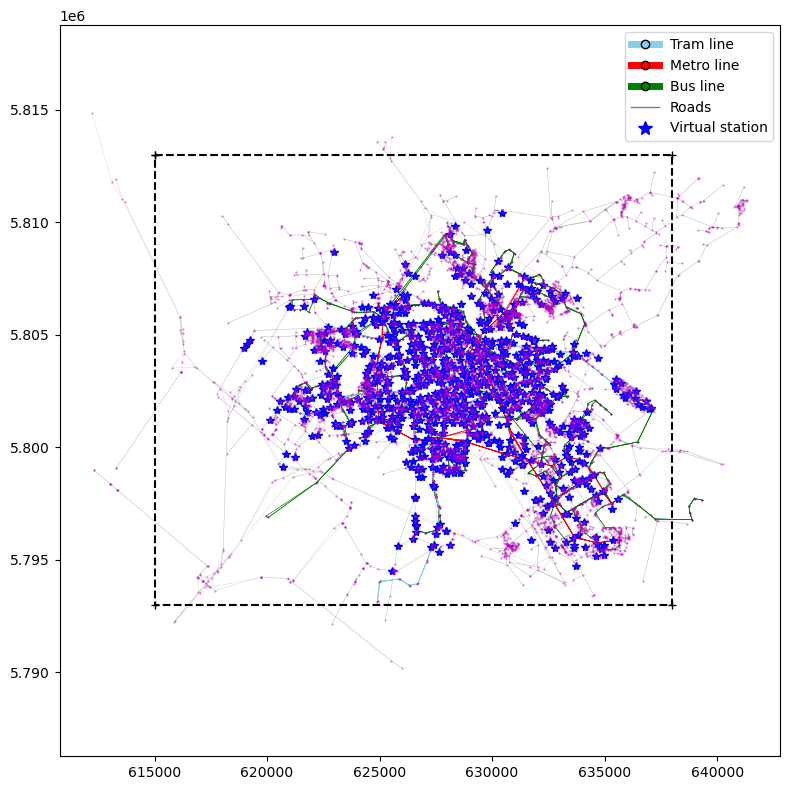

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

plt.plot(x_st, y_st, '*b')

plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

"""for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], 'm:', alpha=0.2)
    plt.plot(d[0], d[1], 'dm', alpha=0.2)
    plt.plot(o[0], o[1], 'om', alpha=0.2)"""

#plt.plot([o_user[0], d_user[0]], [o_user[1], d_user[1]], 'o-')
x=list(polygon[:,0])
x.append(polygon[0,0])
y=list(polygon[:,1])
y.append(polygon[0,1])
plt.plot(x, y, '+--k')

legend = [Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='skyblue', linewidth=5,
            label='Tram line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='red', linewidth=5,
            label='Metro line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='green', linewidth=5,
            label='Bus line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=0, markeredgecolor='grey', markerfacecolor='grey', color='grey', linewidth=1,
            label='Roads'),
          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
            label='Virtual station')]

legend = plt.legend(handles=legend)
#plt.savefig(params['figdir']+'network.pdf')
#plt.xlim([627000,628000])
#plt.ylim([5.8095e6, 5.8105e6])

## Modes shares

In [18]:
def emoped_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return 'emoped1' in modes

def pt_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('BUS' in modes) or ('TRAM' in modes) or ('METRO' in modes)

def calculate_mode_shares(df_paths, list_id):
    emoped_only = 0
    pt_only = 0
    combined = 0
    no_match = 0
    for id in list_id[:]:
        paths = df_paths[df_paths['ID']==id]
        path = paths.iloc[-1]
        modes = path['SERVICES']
        if emoped_in_modes(modes):
            if pt_in_modes(modes):
                combined+=1
            if (not pt_in_modes(modes)):
                emoped_only+=1
        elif pt_in_modes(modes):
            pt_only+=1
        else:
            no_match+=1
    sum = len(list_id)
    return (emoped_only/sum, pt_only/sum, combined/sum, no_match/sum)

In [19]:
list_id = df_path_notax['ID'].unique()

print('notax', calculate_mode_shares(df_path_notax, list_id))
print('tax', calculate_mode_shares(df_path_tax, list_id))
print('subsidy', calculate_mode_shares(df_path_subsidy, list_id))
print('subsidytax', calculate_mode_shares(df_path_subsidytax, list_id))

notax (0.09769645482764254, 0.7114850514621793, 0.03986276752164679, 0.1509557261885313)
tax (0.060284267276588796, 0.7456297990524424, 0.044600555464793336, 0.14948537820617547)
subsidy (0.08364646299624244, 0.6828949518052606, 0.077111583074661, 0.15634700212383598)
subsidytax (0.042966835484397975, 0.7077274955072701, 0.09426564286881228, 0.1550400261395197)


In [20]:
df_path_notax

,ID,EVENT,TIME,COST,PATH,LENGTH,SERVICES,CHOSEN
0,39445,DEPARTURE,16:00:00.00,8.178511,ORIGIN_336 TRAM_12_DIR2_TRAM_12_DIR2_9 TRAM_12...,5616.964902,WALK TRAM WALK METRO WALK BUS WALK,1.0
1,11612,DEPARTURE,16:00:00.00,3.845991,ORIGIN_414 TRAM_4_DIR2_TRAM_4_DIR2_7 TRAM_4_DI...,2317.306423,WALK TRAM WALK,1.0
2,35837,DEPARTURE,16:00:00.00,8.087686,ORIGIN_120 TRAM_2_DIR2_TRAM_2_DIR2_4 TRAM_2_DI...,5591.827041,WALK TRAM WALK TRAM WALK,1.0
3,56283,DEPARTURE,16:00:00.00,3.909962,ORIGIN_381 EMOPEDLayer1_m46397705 EMOPEDLayer1...,1702.034522,WALK emoped1 WALK,1.0
4,31234,DEPARTURE,16:00:00.00,inf,NaN,inf,NaN,NaN
...,...,...,...,...,...,...,...,...
6720,35201,MATCH_FAILURE,18:36:00.00,inf,EMOPEDLayer1_m1422387426,inf,NaN,NaN
6721,60930,MATCH_FAILURE,18:37:00.00,inf,EMOPEDLayer1_m1422387426,inf,NaN,NaN
6722,9782,MATCH_FAILURE,18:38:00.00,inf,EMOPEDLayer1_m46388817,inf,NaN,NaN
6723,28809,MATCH_FAILURE,18:40:00.00,inf,EMOPEDLayer1_m46515529,inf,NaN,NaN


## TTT/TTD

In [21]:
def calculate_tt_td(list_id, df_users):
    TTT = 0
    TTD = 0
    count = 0
    for id in list_id:
        df = df_users[df_users['ID']==id]
        if len(df)>1:
            TTT += Time(df['TIME'].iloc[-1]).to_seconds() - Time(df['TIME'].iloc[0]).to_seconds()
            TTD += df['DISTANCE'].iloc[-1]
            count += 1
    return (TTT/60/count, TTD*1e-3/count)

In [22]:
# Compute total travel time/distance

print(calculate_tt_td(list_id, df_users_notax))
print(calculate_tt_td(list_id, df_users_tax))
print(calculate_tt_td(list_id, df_users_subsidy))
print(calculate_tt_td(list_id, df_users_subsidytax))

(23.98737075437972, 5.858392473543072)
(24.42084024550118, 5.8841985799070375)
(24.180112084376148, 5.873178636396132)
(24.618017727326915, 5.890968169467282)


## Emoped usage

In [23]:
def calculate_emoped_indicators(df_emoped):
    list_emoped = df_emoped['ID'].unique()
    distances = []
    TTD = 0
    TTT = 0
    nb_rides = 0
    for id in list_emoped:
        df = df_emoped[df_emoped['ID']==id]
        TTD += df['DISTANCE'].iloc[-1]
        
        nb_rides_loc = sum(df.STATE=='STOP')-1
        #nb_rides += nb_rides_loc
        i_stops = np.where(df.STATE=='STOP')[0]
        for i in range(nb_rides_loc):
            i_start = i_stops[i]
            i_start_tt = i_stops[i]+1
            i_stop = i_stops[i+1]
            if i_start+1==i_stop:
                pass 
                #print(id)
            else:
                TTT += str_to_time(df.TIME.iloc[i_stop]) - str_to_time(df.TIME.iloc[i_start_tt])
                distances.append(df.DISTANCE.iloc[i_stop] - df.DISTANCE.iloc[i_start])
                nb_rides += 1
                if (df.DISTANCE.iloc[i_stop] - df.DISTANCE.iloc[i_start])<100:
                    print(id, i_stops)
    return (TTD*1e-3, TTT/3600, nb_rides, distances)

def str_to_time(time_str):
    return sum([float(t)*60**(2-i) for i,t in enumerate(time_str.split(':'))])

In [24]:
ttd_notax, ttt_notax, nb_rides_notax, dist_notax = calculate_emoped_indicators(df_emoped1_notax)
ttd_tax, ttt_tax, nb_rides_tax, dist_tax = calculate_emoped_indicators(df_emoped1_tax)
ttd_subsidy, ttt_subsidy, nb_rides_subsidy, dist_subsidy = calculate_emoped_indicators(df_emoped1_subsidy)
ttd_subsidytax, ttt_subsidytax, nb_rides_subsidytax, dist_subsidytax = calculate_emoped_indicators(df_emoped1_subsidytax)

In [25]:
print(sum(np.asarray(dist)==0))
print(ttd_notax/ttt_notax, 'km/h')

0
29.491261909317814 km/h


In [28]:
rev_notax = 1*nb_rides_notax + 0.33*ttt_notax*60
rev_tax = 1*nb_rides_tax + 0.33*ttt_tax*60
rev_subsidy = 1*nb_rides_subsidy + 0.33*ttt_subsidy*60
rev_subsidytax = 1*nb_rides_subsidytax + 0.33*ttt_subsidytax*60

In [29]:
print(ttd_notax, ttt_notax, nb_rides_notax, rev_notax)
print(ttd_tax, ttt_tax, nb_rides_tax, rev_tax)
print(ttd_subsidy, ttt_subsidy, nb_rides_subsidy, rev_subsidy)
print(ttd_subsidytax, ttt_subsidytax, nb_rides_subsidytax, rev_subsidytax)

2363.233121000001 80.13333333333334 809 2395.6400000000003
1608.5117919999982 53.75 624 1688.25
2167.5808489999995 71.35 875 2287.73
1451.4556290000005 45.88333333333333 712 1620.49


(0.0, 11000.0)

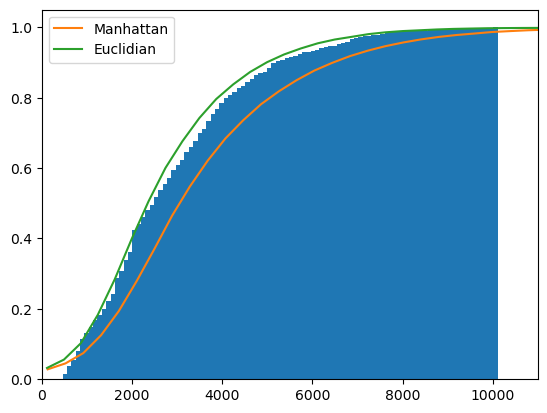

In [30]:
# Calibration
df_dist_mhtn = pd.read_csv('inputs/processed_felyx_data/df_dist_mhtn.csv')
df_dist_eucl = pd.read_csv('inputs/processed_felyx_data/df_dist_eucl.csv')

plt.hist(dist_notax, bins=100, cumulative=True, density=True);
plt.plot(df_dist_mhtn.dist, df_dist_mhtn.dsty, label='Manhattan')
plt.plot(df_dist_eucl.dist, df_dist_eucl.dsty, label='Euclidian')
plt.legend()
plt.xlim([0,11e3])

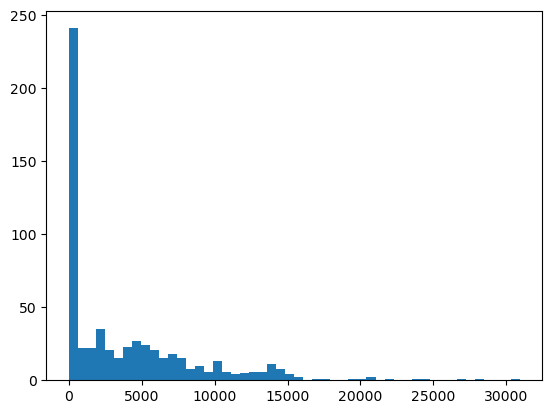

In [31]:
list_emoped = df_emoped1_notax['ID'].unique()
d = []
for id in list_emoped:
    df = df_emoped1_notax[df_emoped1_notax['ID']==id]
    d.append(df['DISTANCE'].iloc[-1])
plt.hist(d, bins=50);

In [32]:
sum([d_==0 for d_ in d])

210

## Station evolution

In [33]:
df_stations['position'] = df_stations.apply(lambda row: '%.3f %.3f'%(row.x_node, row.y_node), axis=1)

In [34]:
df_stations.position

0      620422.006 5801655.356
1      620921.199 5802237.763
2      620575.799 5802043.732
3      620143.643 5801202.518
4      621785.068 5801591.686
                ...          
805    632571.149 5806957.045
806    632643.138 5806724.043
807    631772.347 5806813.012
808    628722.734 5807971.700
809    636414.650 5802510.894
Name: position, Length: 810, dtype: object

In [35]:
station_emoped = np.zeros((len(df_stations), df_stations.nb_emoped.sum()))
nb_emoped_stations = np.zeros((len(df_emoped1_notax.TIME.unique()), len(df_stations)), int)
for i_t, t in enumerate(df_emoped1_notax.TIME.unique()):
    df = df_emoped1_notax[df_emoped1_notax.TIME==t]
    df2 = df[df.STATE=='STOP']
    for i,row in df2.iterrows():
        i_sta = df_stations.index[df_stations.position==row.POSITION][0]
        station_emoped[:, row.ID] = 0
        station_emoped[i_sta, row.ID] = 1
    df3 = df[df.STATE!='STOP']
    for i,row in df3.iterrows():
        station_emoped[:, row.ID] = 0
    nb_emoped_stations[i_t] = station_emoped.sum(axis=1)
    

In [36]:
df_stations.index[df_stations.position==row.POSITION][0]

809

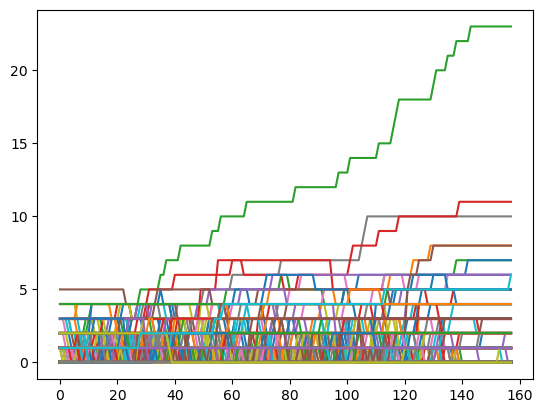

In [37]:
plt.plot(nb_emoped_stations);
#plt.ylim([0,5])

In [38]:
net_length = 0
for name_sect in mmgraph_pt.roads.sections:
    sect = mmgraph_pt.roads.sections[name_sect]
    net_length += sect.length
print(net_length*1e-3)

3635.8550884490164
